In [1]:
import numpy as np
import pandas as pd

from BC_class import BC
from auxiliary import *

from scipy.spatial.distance import pdist
from scipy.optimize import least_squares

from fancyimpute import IterativeImputer
from sklearn.linear_model import LassoCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2, rc={'figure.figsize':(16,9)})

Using TensorFlow backend.


---
Let's look what the first rows of the file with data are

In [2]:
columns = pd.read_excel("Data_finish.xlsx", header=None, nrows=5)
columns

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Геолог.,Глубина,Геол.,Литотип,Диаметр,Карбонатность,Объемная,Минерало-гическая,Открытая,Общая,Абсолютная,"Остаточ-ная водо-насыщен-ность,",Эффек-тивная,Приме-чание
1,№,отбора,возраст,породы,"образца,",(% раствори- мых солей,"плотность,","плотность,","пористость,","пористость,",прони-,%,"порис-тость,",NaN
2,образца,"керна,",NaN,NaN,см,в 10% р-ре HCL),с учетом,г/см3,%,%,"цаемость,",NaN,%,NaN
3,NaN,м,NaN,NaN,NaN,NaN,"каверн,",NaN,NaN,NaN,10-15м2,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,г/см3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


First 5 rows are the column names.  
Extract the names as follows:

In [3]:
columns = columns.replace(np.nan, '')
names = columns.applymap(parser1).sum().apply(parser2).values # info about `parsers` is in auxilary.py
print(*names, sep='\n')

Геолог. № образца
Глубина отбора керна, м
Геол. возраст
Литотип породы
Диаметр образца, см
Карбонатность (% растворимых солей в 10% р-ре HCL)
Объемная плотность, с учетом каверн, г/см3
Минералогическая плотность, г/см3
Открытая пористость, %
Общая пористость, %
Абсолютная проницаемость, 10-15м2
Остаточная водонасыщенность,  %
Эффективная пористость, %
Примечание


manual processing

In [4]:
# for better-looking printing
names[5] = "Карбонатность (%\n растворимых солей\n в 10% р-ре HCL)"
names[6] = 'Объемная плотность,\nс учетом каверн, г/см3' 

In [5]:
indices = [x for x in range(14) if x not in [5,6]]
for i in indices:
    names[i] = names[i].replace(' ', '\n', 1)
    done = False

---
Load the data

In [6]:
df = pd.read_excel("Data_finish.xlsx", names=names, skiprows=4)
columns = df.columns
df.head()

,Геолог. № образца,"Глубина отбора керна, м",Геол. возраст,Литотип породы,"Диаметр образца, см",Карбонатность (% растворимых солей в 10% р-ре HCL),"Объемная плотность, с учетом каверн, г/см3","Минералогическая плотность, г/см3","Открытая пористость, %","Общая пористость, %","Абсолютная проницаемость, 10-15м2","Остаточная водонасыщенность, %","Эффективная пористость, %",Примечание
0,1/8,"725,75",Р2р,Мергель,скол,38430.0,1942.0,2804.0,32161.0,32161.0,-1000.000,79369.0,7854.0,NaN
1,1/18,"726,80",Р2р,Изв. гл.,"2,7",98490.0,2152.0,2835.0,25042.0,25042.0,0.210,69489.0,8473.0,NaN
2,1/25-26,"727,50",Р2р,Глины,скол,4200.0,1922.0,2709.0,30534.0,30534.0,-1000.000,-1000.0,-1000.0,NaN
3,1/33,"728,30",Р2р,Гл. изв.,"2,7",14910.0,1984.0,2730.0,28424.0,28424.0,-1000.000,93965.0,2982.0,NaN
4,1/39,"728,90",Р2р,Изв. гл.,"2,7",82635.0,2016.0,2856.0,30775.0,30775.0,0.315,83916.0,6184.0,трещ.


Some statics about the data we have

In [7]:
df.describe()

,Карбонатность (% растворимых солей в 10% р-ре HCL),"Объемная плотность, с учетом каверн, г/см3","Минералогическая плотность, г/см3","Открытая пористость, %","Общая пористость, %","Абсолютная проницаемость, 10-15м2","Остаточная водонасыщенность, %","Эффективная пористость, %"
count,344.000000,344.000000,344.000000,344.000000,344.000000,3.440000e+02,344.000000,344.000000
mean,32311.360073,2262.136628,2829.500000,20896.863372,21231.040698,1.513495e+05,36271.712959,9930.620799
std,41610.079234,233.954174,71.179853,8649.198985,8689.119232,2.768981e+05,36649.043692,10533.990136
min,-1000.000000,1449.000000,2594.000000,1166.000000,1166.000000,-1.000000e+03,-1000.000000,-1000.000000
25%,0.000000,2089.000000,2772.000000,15031.250000,15477.500000,2.100000e-01,4533.000000,0.178000
50%,3727.500000,2294.000000,2814.000000,20071.000000,20869.000000,1.365000e+03,21572.000000,9045.500000
75%,81401.250000,2436.000000,2877.000000,26683.500000,26683.500000,2.325225e+05,67391.500000,20126.250000
max,104895.000000,2877.000000,3035.000000,47943.000000,47943.000000,1.560510e+06,104958.000000,39858.000000


---
*Preprocessing of the data retrived from the excel file*   
We have a problem here:  wrong comma position in the table entries (moreover, it relates only particular excel cells of the file - but I have solved it, look below how)

In [8]:
#remove separation lines
df = df.dropna(how="all")

#fix wrong values
df[df.columns[5:-1]] = df[df.columns[5:-1]].applymap(lambda x: x if np.isnan(x) or x - int(x) else x / 1000)

#replace all negative values with NaN
df[df.describe().columns] = df[df.describe().columns].applymap(lambda x: np.nan if x < 0 else x)

#convert column "Глубина отбора керна, м" to type float
if type(df.iloc[0,1]) is str:
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1].apply(lambda x: x.replace(',','.')))

Data stats after processing

In [9]:
df.describe()

,"Глубина отбора керна, м",Карбонатность (% растворимых солей в 10% р-ре HCL),"Объемная плотность, с учетом каверн, г/см3","Минералогическая плотность, г/см3","Открытая пористость, %","Общая пористость, %","Абсолютная проницаемость, 10-15м2","Остаточная водонасыщенность, %","Эффективная пористость, %"
count,344.000000,275.000000,344.000000,344.00000,344.000000,344.000000,326.000000,266.000000,266.000000
mean,1526.661657,40.712585,2.262137,2.82950,20.896863,21.231041,159.884248,47.209492,13.228060
std,274.256342,42.595465,0.233954,0.07118,8.649199,8.689119,281.998737,34.769345,9.786015
min,725.750000,0.000000,1.449000,2.59400,1.166000,1.166000,0.001000,0.515000,0.002000
25%,1507.712500,1.732500,2.089000,2.77200,15.031250,15.477500,0.315000,17.655750,2.294250
50%,1600.075000,11.025000,2.294000,2.81400,20.071000,20.869000,1.785000,33.778500,13.666000
75%,1610.612500,88.935000,2.436000,2.87700,26.683500,26.683500,245.437500,89.205500,21.236250
max,2012.480000,104.895000,2.877000,3.03500,47.943000,47.943000,1560.510000,104.958000,39.858000


---
After I reported this problem, I got the new data (the same data but with the problem fixed).   
The new data format is quite akward. It differs from the previous one by splitting data in chunks according to the value in the first column of the old excel file. Each chunk is placed in a separate file. Comparing with the old data, the order of new one's entries is different and if you restore the old order ... What the heck! Values do not coincide: old and new ones. And it is not because of rougher rounding.

Let's check if there is really sth to worry about

In [10]:
catch = lambda x: int(x.split('/')[0])
print('#', 'reldiff', 'val1', 'val2', sep='\t')
for i in range(1,13):
    group = df[df.iloc[:,0].apply(catch) == i]
    xl_values = group.iloc[:,5:-1].values
    xl_values = xl_values[xl_values[:,0].argsort()]

    file = np.loadtxt("New_Data/Data%02d.txt" % i)
    file[file < 0] = np.nan
    file = file[file[:,0].argsort()]
    
    diff = xl_values - file
    diff[np.isnan(diff)] = 0
        
    xl_values[np.isnan(xl_values)] = 0

    np.divide(diff, xl_values, out=diff, where = xl_values!=0)
    amax = diff.argmax()
    maxi = diff.max()
    f1 = xl_values.flatten()[amax]
    f2 = file.flatten()[amax]
    print("%d\t%.5f\t%.3f\t%.3f" % (i, maxi, f1, f2))

#	reldiff	val1	val2
1	0.04788	1.817	1.730
2	0.04789	1.775	1.690
3	0.06250	0.032	0.030
4	0.06250	0.032	0.030
5	0.06250	0.032	0.030
6	0.05660	0.053	0.050
7	0.04781	2.552	2.430
8	0.05263	0.095	0.090
9	0.06250	0.032	0.030
10	0.06250	0.032	0.030
11	0.06250	0.032	0.030
12	0.04891	0.368	0.350


What I have also noticed is that some excel cells containing NaNs in the old file in the new one have value 0. I take into account "this peculiarity" in the code cell above as well. But nevertheless, the results are comforting: the values from new and old data are the same w.r.t. relative error less than 7%. It also confirms that I have correctly processed the old data

---
I decided to stick with the old data. Since it is more convinient for me.  

---
Plot where NaNs are (NaN is represented by a black dash on the plot below)

data size now is (344, 14)


Геолог.\n№ образца                                          0
Глубина\nотбора керна, м                                    0
Геол.\nвозраст                                              0
Литотип\nпороды                                             0
Диаметр\nобразца, см                                        0
Карбонатность (%\n растворимых солей\n в 10% р-ре HCL)     69
Объемная плотность,\nс учетом каверн, г/см3                 0
Минералогическая\nплотность, г/см3                          0
Открытая\nпористость, %                                     0
Общая\nпористость, %                                        0
Абсолютная\nпроницаемость, 10-15м2                         18
Остаточная\nводонасыщенность,  %                           78
Эффективная\nпористость, %                                 78
Примечание                                                281
dtype: int64

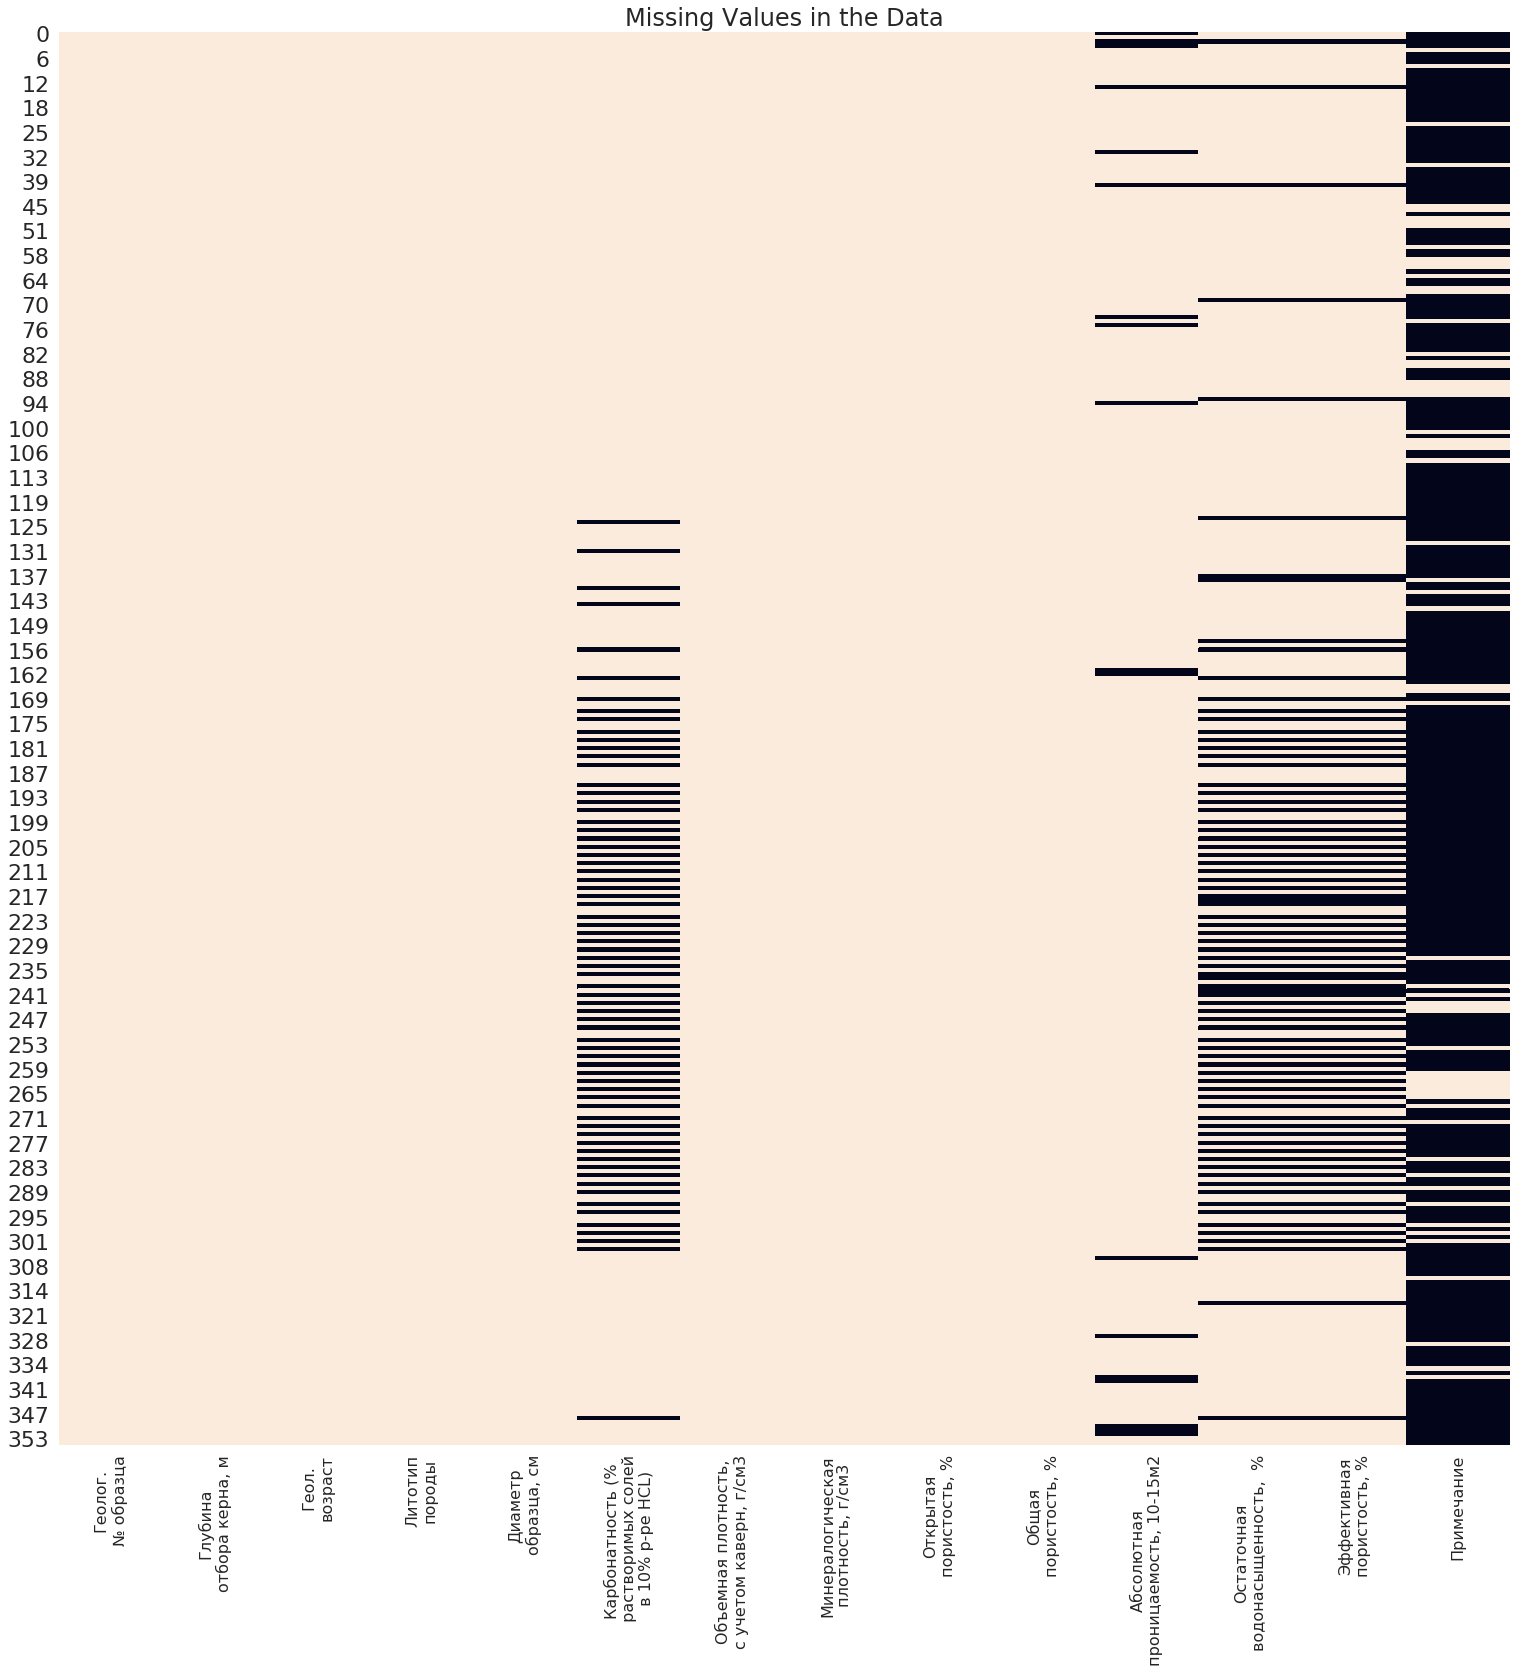

In [11]:
plt.figure(figsize=(26,26))
sns.heatmap(df.notna(), cbar=False)
plt.title("Missing Values in the Data")
plt.xticks(fontsize=16)
plt.savefig("missing.png")

print("data size now is", df.shape)
df.isna().sum()

---
Extract desired features

In [12]:
df_wona = df.dropna(subset=columns[:-1]) # dataframe without NaNs
print(df_wona.shape)

(247, 14)


---
A small function built on previously written code for printing results

In [13]:
def get_results_with_FD(data, delmin=.5):
    bc = BC(data)
    x,y = bc.FD_curve(eps=delmin)
    
    # Approximate the FD graph with msigma
    x0 = np.array([1,-3,0,0])
    res_lsq = least_squares(my_fun,x0,jac=jac_fun,args=(x, y))
    coefs = res_lsq.x
    print("msigma coefs (check if within normal parameters):\n",coefs)

    FDE = dmsigma(-res_lsq.x[2]/res_lsq.x[1], *res_lsq.x) 
    print("\nFD estimate:", FDE)

    plot_results(x, y, FDE, coefs)
    
    return x, y

---
## Pearson Correlation and Fractal Dimension (Warm Up)

Get some vision with a provisional result

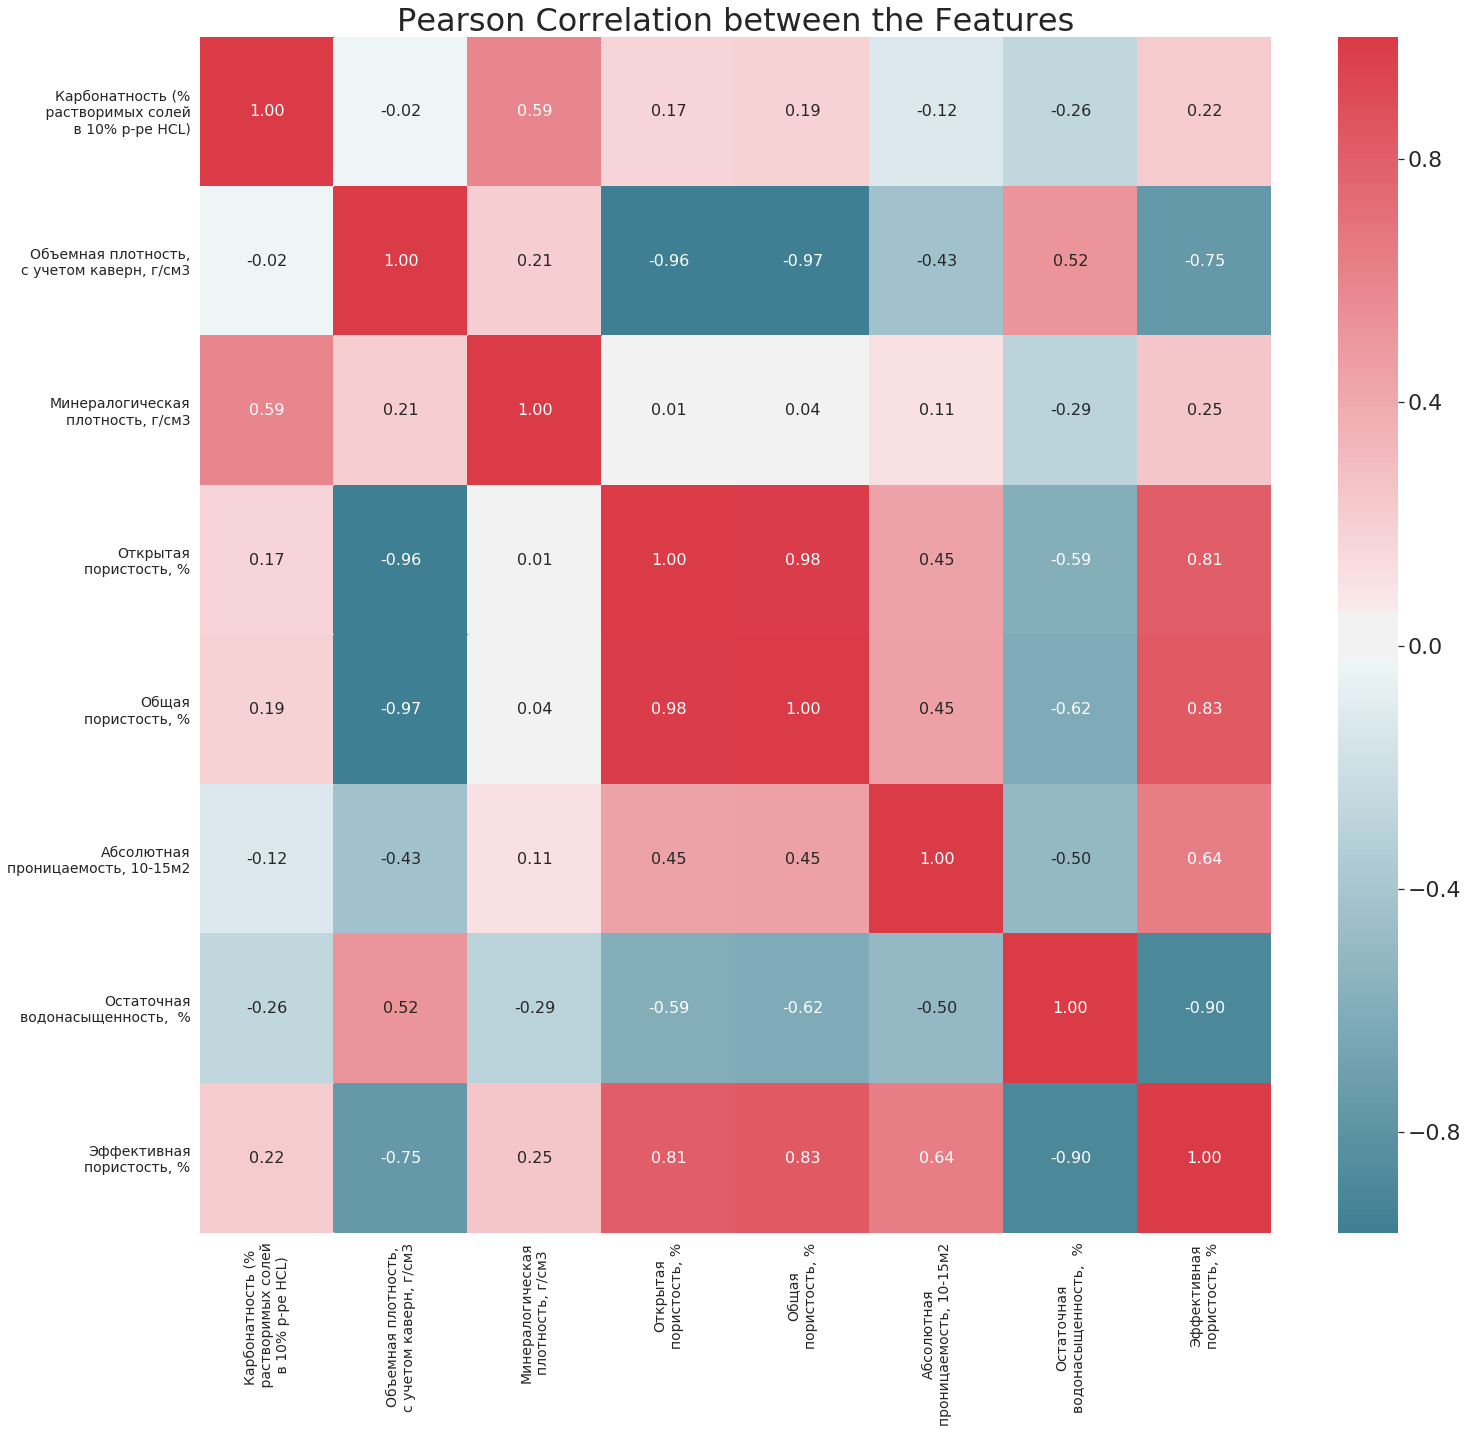

In [14]:
plt.figure(figsize=(24,22))
corr = df_wona.iloc[:,5:-1].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f', annot_kws={"size": 16})
plt.title("Pearson Correlation between the Features", size=32)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("pearson.png")

You can notice here some feature pairs that are (anti)correlated. For example: открытая пористость and общая пористость, объёмная плотность с учётом каверн and общая пористость and so on 

Check correlation of открытая пористость and общая пористость with FD

msigma coefs (check if within normal parameters):
 [ 9.41582279 -0.40660363  0.53649116  7.59138772]

FD estimate: 0.9571269406082945


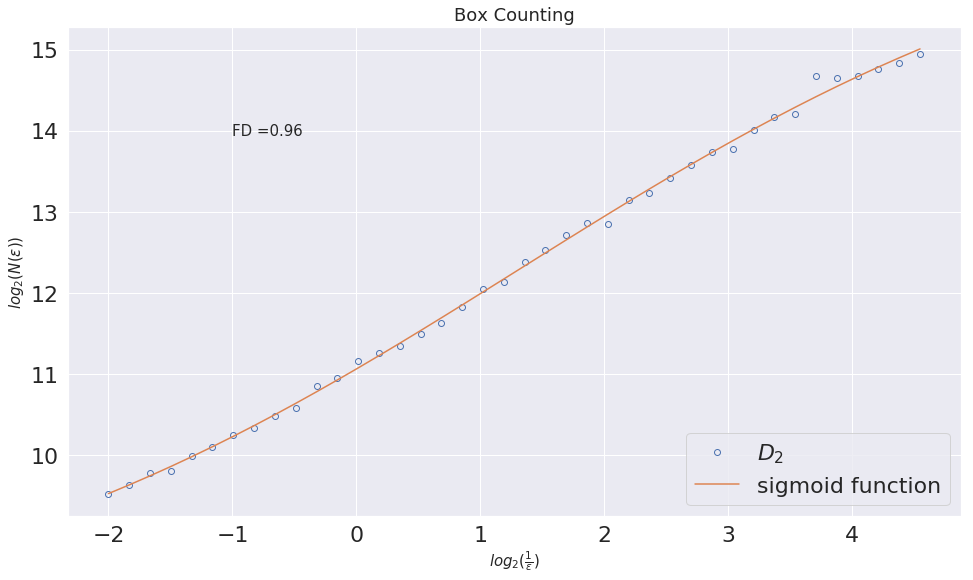

In [15]:
data = df_wona.iloc[:,[8,9]].values # открытая пористость and общая пористость
get_results_with_FD(data);

Similar to Pearson correlation FD also says that the two chosen features are strongly correlated

---
## Lasso and Fractal Dimension

Use Lasso lin.reg.model as a feature selection method

In [16]:
tmp = df_wona.iloc[:,5:-1].drop(columns[-4],axis=1)
X_tr = tmp.values
cols = tmp.columns
y_tr = df_wona.iloc[:,10].values

alphas = np.linspace(3, 20, 1000)
reg = LassoCV(alphas=alphas, cv=3) # default arguments are OK
reg.fit(X_tr, y_tr)

LassoCV(alphas=array([ 3.     ,  3.01702, ..., 19.98298, 20.     ]),
    copy_X=True, cv=3, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

---
Here the results.
Presentation form: 'feature_name, its_weight'

In [17]:
print(*zip(cols, reg.coef_), sep='\n')

('Карбонатность (%\n растворимых солей\n в 10% р-ре HCL)', -1.4932256214184034)
('Объемная плотность,\nс учетом каверн, г/см3', 0.0)
('Минералогическая\nплотность, г/см3', 0.0)
('Открытая\nпористость, %', 0.0)
('Общая\nпористость, %', -13.843115880762548)
('Остаточная\nводонасыщенность,  %', 4.3711120872761455)
('Эффективная\nпористость, %', 43.44423895379872)


---
Heuristic FD estimation (from the LassoCV results)

In [18]:
np.abs(reg.coef_).sum() / np.abs(reg.coef_).max() 

1.4536263970561256

---
Try to get the similar result with the BC algorithm
1. for the same dataset as it was with Lasso

msigma coefs (check if within normal parameters):
 [ 8.3612677  -0.71120182  3.59524192  7.77461614]

FD estimate: 1.4866372045004572


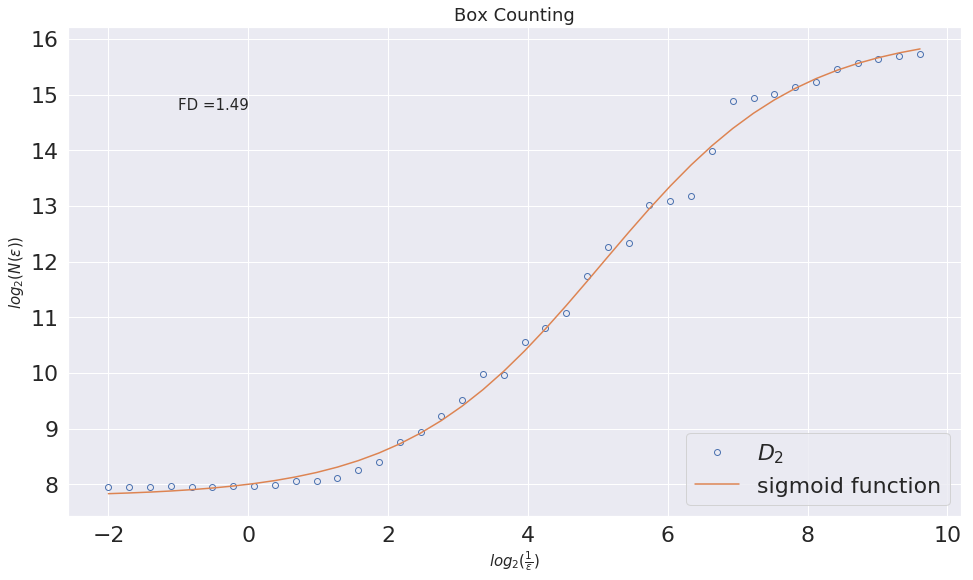

In [19]:
data = np.hstack((X_tr,y_tr[:,None]))
#data = df_wona.iloc[:,5:-1].values
get_results_with_FD(data);

# A good validity check: FD does not depend on columns order nor on that of rows. Test by uncommenting 2nd line

2. for dataset resulted by discarding the features with zero weight in Lasso model

msigma coefs (check if within normal parameters):
 [ 8.37323139 -0.71370558  3.59387331  7.773616  ]

FD estimate: 1.4940054997635392


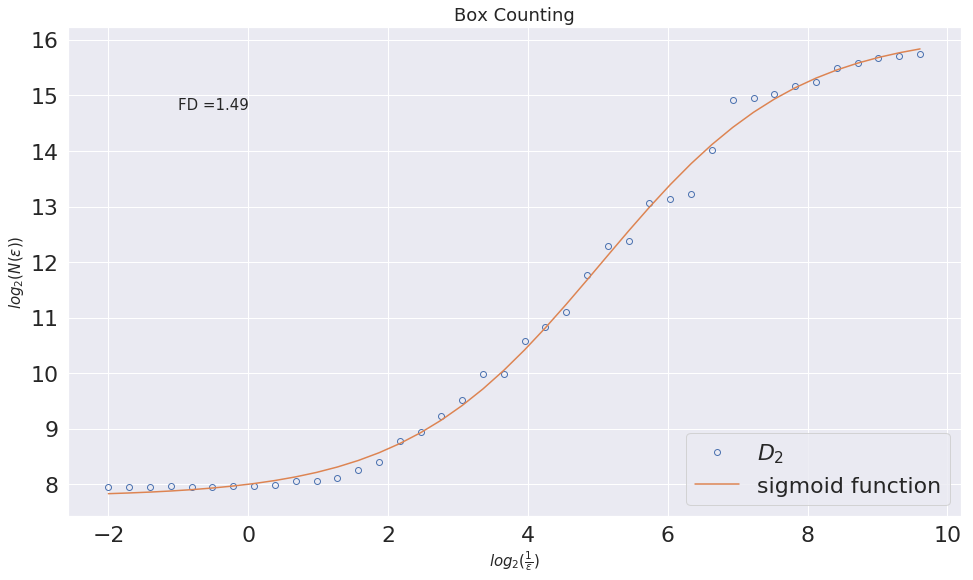

In [20]:
data = df_wona.iloc[:,5:-1].drop(columns[6:9], 1).values
get_results_with_FD(data);

Therefore, BC methods gave the results which are completely consistent with those of Lasso 
(I conclude it from the fact that FD does not change after excluding the features which were eliminated by Lasso [and partially from the result of the code cell that follows Lasso weights])

---
Let's see if for different lithotypes the same relation holds
1. Start with a display of the most numerous classes

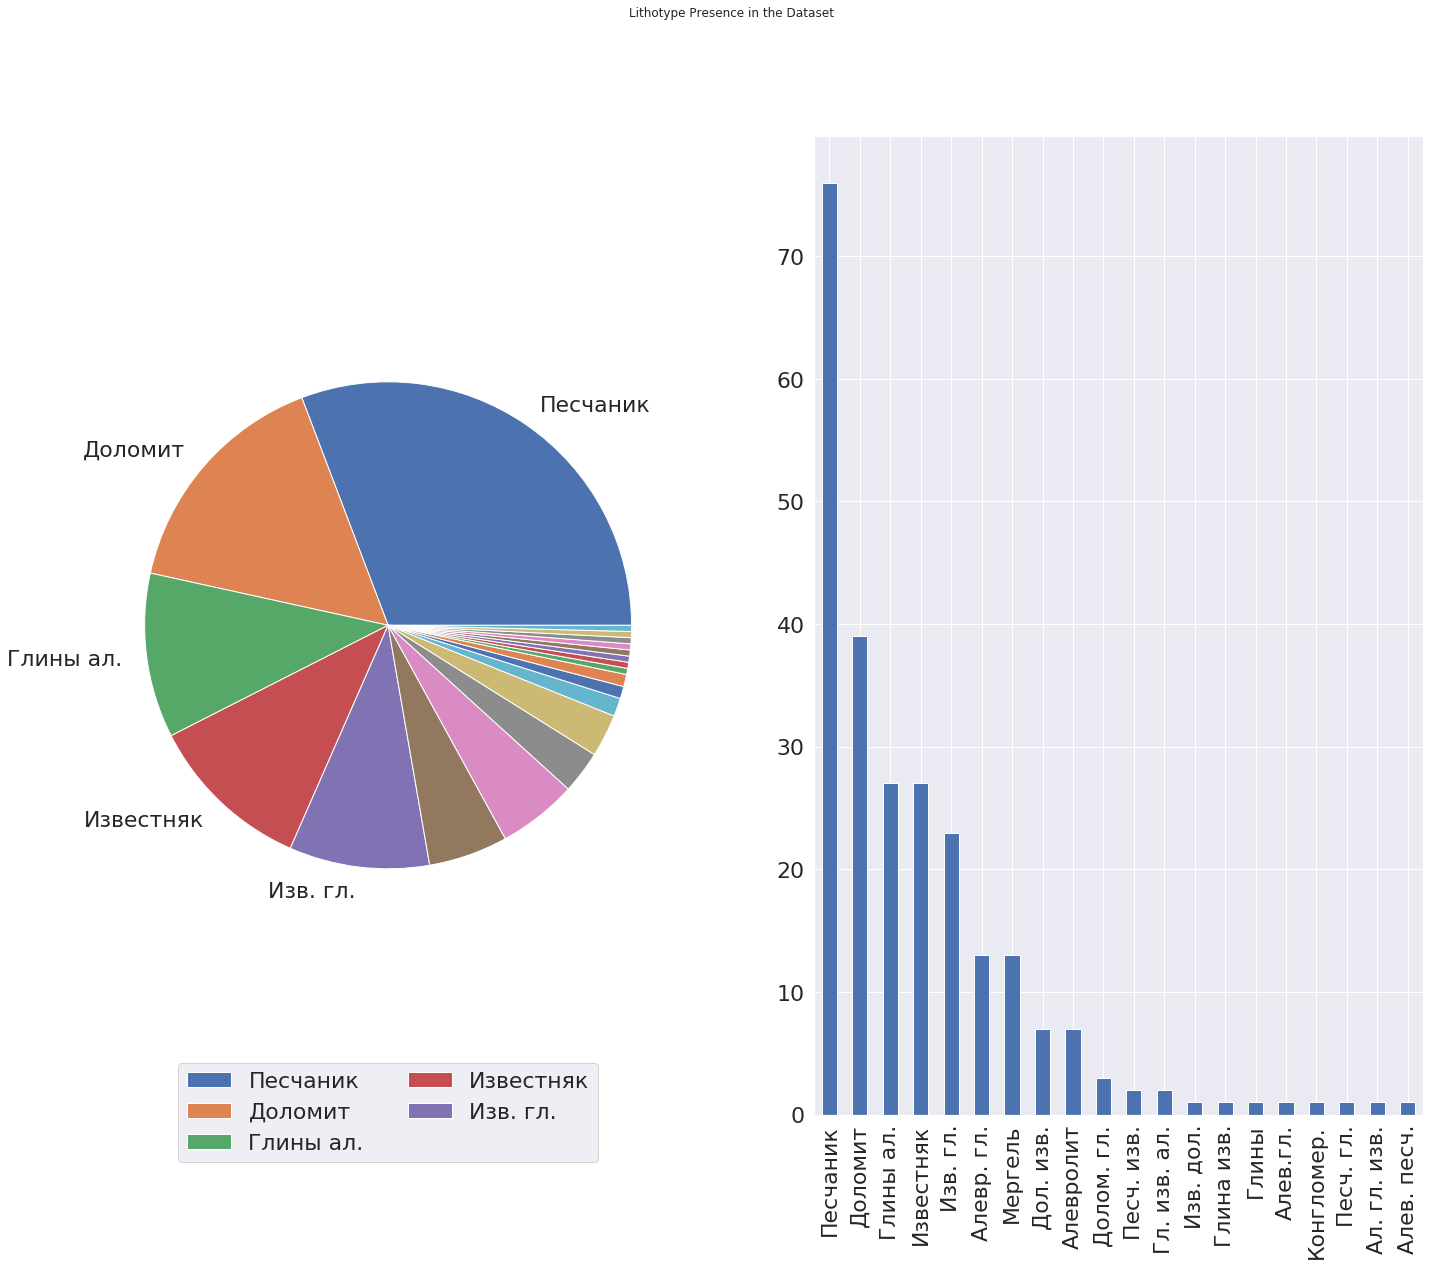

In [21]:
counts = df_wona[columns[3]].value_counts()
fig,ax = plt.subplots(1, 2, figsize=(24,18))
fig.suptitle("Lithotype Presence in the Dataset")
axis = counts.plot.bar(ax=ax[1])
big5 = [x.get_text() if i < 5 else '' for i,x in enumerate(axis.get_xticklabels())]
counts.plot.pie(ax=ax[0], labels=big5)
ax[0].set_ylabel('')
ax[0].legend(
    ncol = 2,
    loc="lower center",
    bbox_to_anchor=(0, -.4, 1, 1));

It is impossible to get reasonoble results when having such scarce data on a single lythotype (30-50 samples). In addition, classes are not balanced. 
Maybe, when dealing with FD, situation is not so bad. (Nevertheless, if I'm asked to do it..)

---
Select 4 large categories

In [22]:
selected = big5[:4]

x0 = np.array([1,3,0,0])
FDE_list = []
for i in range(4):
    data = df_wona[df_wona[columns[3]] == selected[i]][columns[5:-1]].values
    bc = BC(data)
    x,y = bc.FD_curve(eps=.5)
    res_lsq = least_squares(my_fun,x0,jac=jac_fun,args=(x, y))
    FDE_list.append(dmsigma(-res_lsq.x[2]/res_lsq.x[1],*res_lsq.x))
print(*zip(selected,FDE_list),sep='\n')
print("\nmean: %.2f" % np.mean(FDE_list))

('Песчаник', 1.1495013692312448)
('Доломит', 1.376764319158855)
('Глины ал.', 1.3375133074398784)
('Известняк', 1.7671625355207314)

mean: 1.41


Possibly, for different lythotypes the realation among features is different. It would be interesting to check this on big data.

---
# Experimental Part

---
Try to impute most of the nans

In [23]:
add_cat_features = False
if add_cat_features:
    XY_incomplete = df.drop(columns[-1],1)
    for i in [0,2,3,4]:
        XY_incomplete.iloc[:,i] = df.iloc[:,i].factorize()[0]

In [24]:
if not add_cat_features:
    XY_incomplete = df.values[:,5:-1]

n_imputations = 200
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(XY_incomplete))

XY_completed_mean = np.mean(XY_completed, 0)
XY_completed_std = np.std(XY_completed, 0)
tmp = pd.DataFrame(XY_completed_mean)

In [25]:
imputed_data = tmp[tmp >= 0].dropna()
imputed_data = imputed_data.reset_index(drop=True)
print("data shape now is :", imputed_data.shape)

data shape now is : (337, 8)


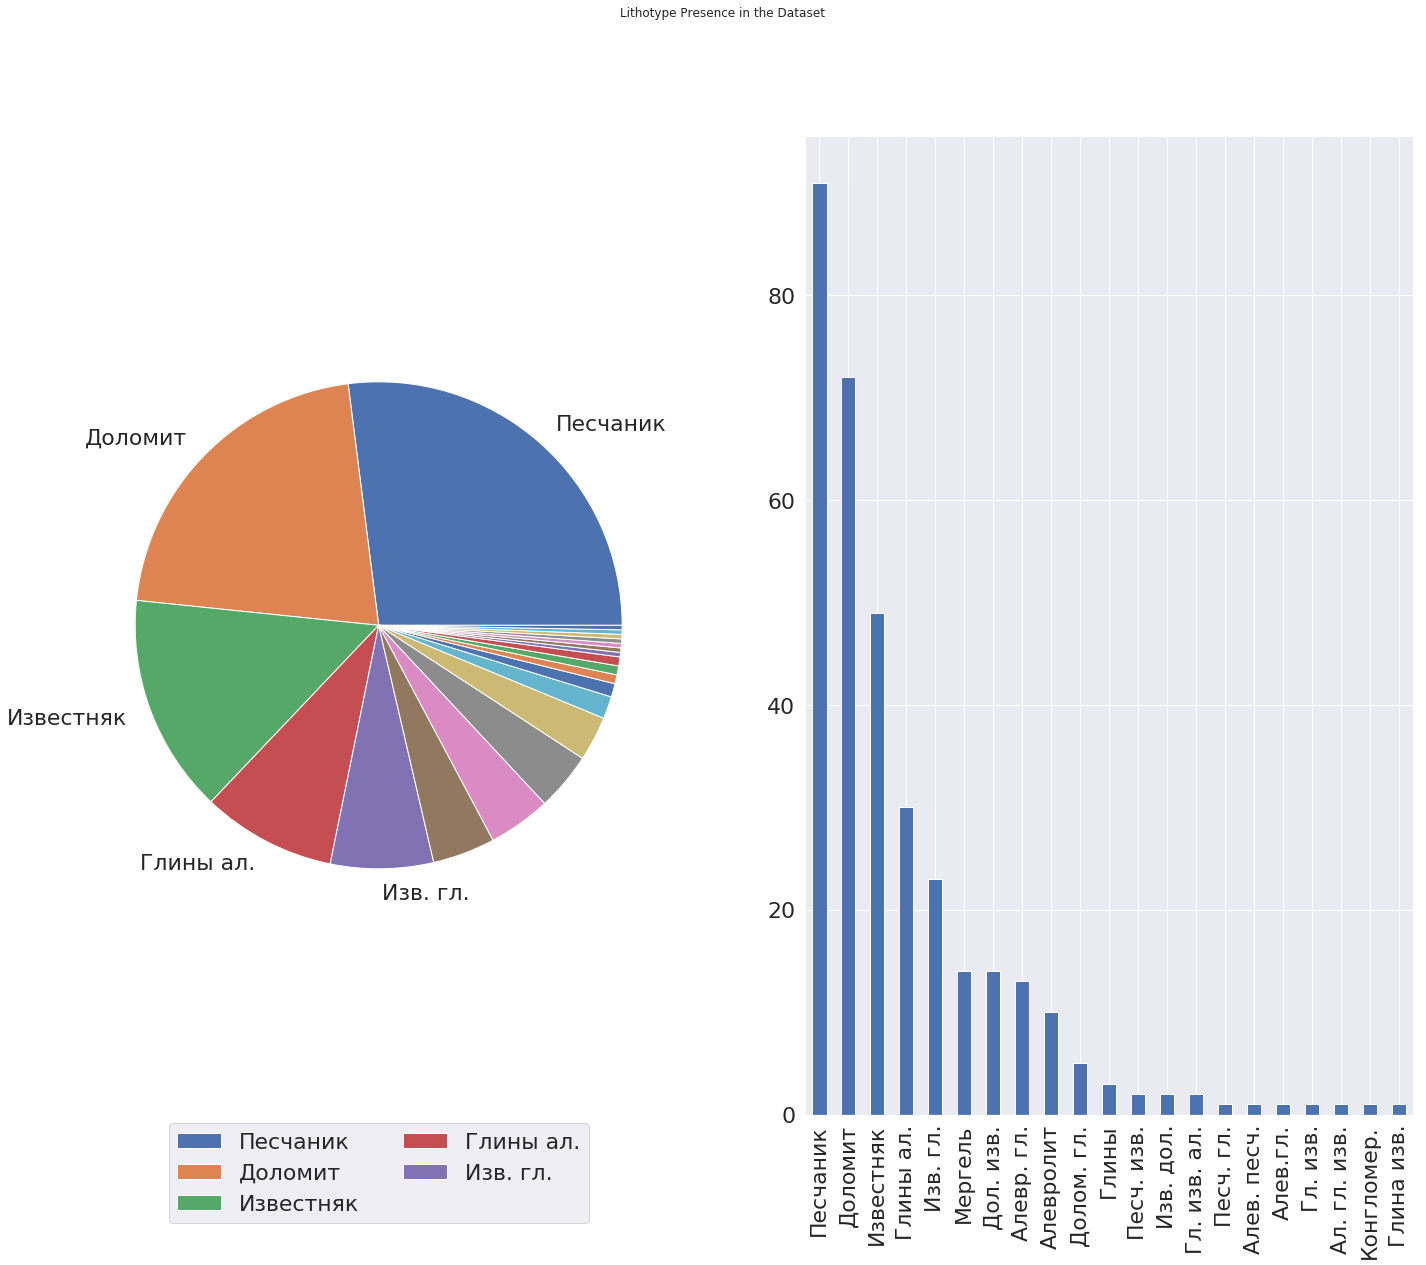

In [26]:
indices = np.arange(len(df))[np.all(tmp >= 0,1)]
counts = df.iloc[indices][columns[3]].value_counts()
fig,ax = plt.subplots(1,2,figsize=(24,18))
fig.suptitle("Lithotype Presence in the Dataset")
axis = counts.plot.bar(ax=ax[1])
big5 = [x.get_text() if i < 5 else '' for i,x in enumerate(axis.get_xticklabels())]
counts.plot.pie(ax=ax[0],labels=big5)
ax[0].set_ylabel('')
ax[0].legend(
    ncol = 2,
    loc="lower center",
    bbox_to_anchor=(0, -.5, 1, 1));

In [27]:
imputed_data = pd.concat((df.iloc[indices,:5].reset_index(drop=True), imputed_data), 1)

In [28]:
selected = big5[:4]

x0 = np.array([1,3,0,0])
FDE_list = []
for i in range(4):
    data = imputed_data[imputed_data[columns[3]]\
         == selected[i]].iloc[:,5:-1].values
    bc = BC(data)
    x,y = bc.FD_curve()
    res_lsq = least_squares(my_fun,x0,jac=jac_fun,args=(x, y))
    FDE_list.append(dmsigma(-res_lsq.x[2]/res_lsq.x[1], *res_lsq.x))
print(*zip(selected,FDE_list),sep='\n')
print("\nmean: %.2f" % np.mean(FDE_list))

('Песчаник', 1.2535733802309712)
('Доломит', 1.5711520952039786)
('Известняк', 1.3168552832484788)
('Глины ал.', 1.5414216499140305)

mean: 1.42


**With the categorical features imputation is competely failed it is seen from the resulting FD values (toggle `add_cat_features` to have a look). The reflections below concern only the continuous features**

The increase in dolomite FD can be understood by looking at the table below

In [29]:
df[columns[3]][df.iloc[:,:-1].isna().any(1)].value_counts()

Доломит       36
Известняк     22
Песчаник      15
Дол. изв.      7
Алевролит      3
Мергель        3
Глины ал.      3
Глины          2
Долом. гл.     2
Гл. изв.       2
Глина изв.     1
Изв. дол.      1
Name: Литотип\nпороды, dtype: int64

The largest number of objecs which were thrown out are dolomite (almost half of total count of dolomite rocks). The samples which were added after filling in missing values, in the case of dolomit turned out to be of "new nature" (drawn from a distribution distinct from that according to which objects were distributed originally, of "higher dimension"). The number of limestone samples has grown significantly as well. In contrast to dolomite, limestone's FD has deacresed a bit. This means that the imputed data, referred to this lithotype, are from "sub-distribution" (set of points of distribution of smaller dimension) of the "old points". What is written here is almost complete tautology. It just explains what has happend and does not tell about why it has. Are the imputed values close to those which must be in reality?

# More Checks on the Correctness of BC algorithm

---
As expected zero completion of NaNs leads to FD flattening

In [30]:
from scipy.optimize import least_squares
from imageio import imread
from math import log

In [31]:
df_zeroin = df.iloc[:,5:-1].fillna(0)

In [32]:
bc = BC(df_zeroin.values)
x,y = bc.FD_curve()
res_lsq = least_squares(my_fun,x0,jac=jac_fun,args=(x, y))
FDE = dmsigma(-res_lsq.x[2]/res_lsq.x[1],*res_lsq.x) # FD estimate
print(FDE)

1.3068531783478112


**Let us obtain for Sierpinski triangle its FD value. The approximation of FD with "sigmoid" function is automated, yet not precise. It is enough for comparison of diff. datasets by FD, but not for showing the abs. value of the fractal dimension** 

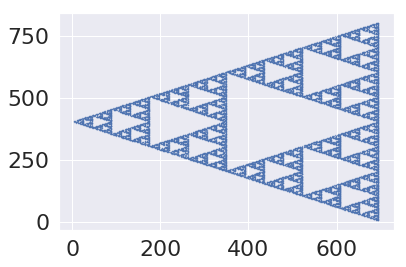

In [33]:
triangle = imread("triangle.jpg")

pixels = np.add.reduce(triangle,axis=2)
x,y = np.where(pixels==0)
data = np.hstack((x[:,np.newaxis],y[:,np.newaxis]))

plt.scatter(x, y, .1);

msigma coefs (check if within normal parameters):
 [15.52056068 -0.46001588  2.34650927 13.27615483]

FD estimate: 1.784926104904257


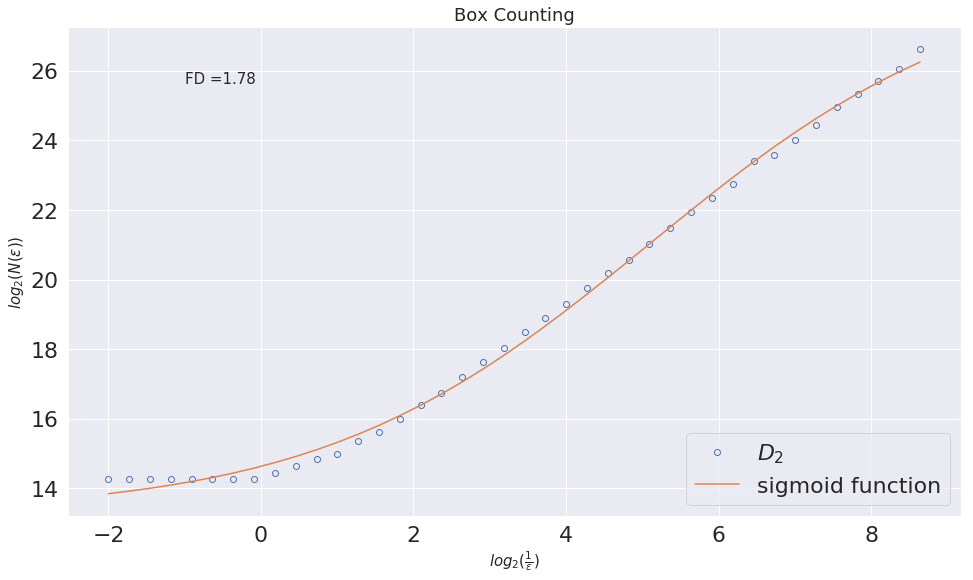

In [34]:
x,y = get_results_with_FD(data)

**In order to get a more precise estimate, we approximate the linear segment of the graph with a line**

In [35]:
linapprox(x, y)

Enter the boundary values separated by space:3 6


1.576395991550273

The value obtained by the analytic expression:

In [36]:
log(3) / log(2)

1.5849625007211563